In [62]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

os.chdir("/home/william/Desktop")

In [63]:
datosTicTacToe = pd.read_csv("tic-tac-toe.csv")

In [64]:
for x in datosTicTacToe:
    if x != " Gana-x":
        datosTicTacToe[x] = datosTicTacToe[x].astype('category')
datosTicTacToe.dtypes

cuadro-superior-izquierdo     category
 cuadro-superior-medio        category
 cuadro-superior-derecho      category
 cuadro-medio-izquierdo       category
 cuadro-medio-medio           category
  cuadro-medio-derecho        category
 cuadro-inferior-izquierdo    category
 cuadro-inferior-medio        category
 cuadro-inferior-derecho      category
 Gana-x                         object
dtype: object

In [65]:
datosTicTacToePosiblesResultados = list(set(datosTicTacToe.iloc[:, -1]))

In [66]:
class PrediccionBase:
    def __init__(self, datos):
        self.__datos = self.cleaning(datos)
        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__verdaderosNegativos = 0
        self.__falsosPositivos = 0
        self.__falsosNegativos = 0
        self.__verdaderosPositivos = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def datos(self):
        return self.__datos

    @property
    def reporte(self):
        return self.__reporte

    def cleaning(self, datos):
        datos = datos.replace({'x': 0, 'o': 1, 'b': 2})
        return datos

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global],
            "Verdaderos Positivos": [self.__verdaderosPositivos],
            "Verdaderos Negativos": [self.__verdaderosNegativos],
            "Falsos Negativos": [self.__falsosNegativos],
            "Falsos Positivos": [self.__falsosPositivos]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo):
        self.__verdaderosNegativos, self.__falsosPositivos, self.__falsosNegativos, self.__verdaderosPositivos = MC.ravel()
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}


class PrediccionADABoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, criterion="gini", splitter="best", min_samples_split=2):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        self.__instancia = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=None,
                                                  criterion=criterion, splitter=splitter)
        self.__instancia_potenciacion = AdaBoostClassifier(base_estimator=self.__instancia,
                                                           n_estimators=100, random_state=0)
        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Bosques Aleatorios ADA Boosting")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionXGBoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, n_estimators=10, random_state=0, min_samples_split=2):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = GradientBoostingClassifier(n_estimators=n_estimators, random_state=n_estimators,
                                                                   min_samples_split=min_samples_split, max_depth=None)

        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Bosques Aleatorios XG Boosting")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionRandomForest(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, n_estimators=10):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = RandomForestClassifier(n_estimators=n_estimators, random_state=0)

        self.__x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, "Bosques Aleatorios")
        for k in indices:
            print("\n%s:\n%s" % (k, str(indices[k])))

In [67]:
prediccionADABosting = PrediccionADABoosting(datos=datosTicTacToe)
prediccionADABosting.entrenamiento(train_size=0.80)


Matriz de Confusión:
[[ 56  18]
 [  3 115]]

Precisión Global:
0.890625

Error Global:
0.109375

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.756757                 0.974576


[0.11262988 0.07880623 0.08039373 0.10569753 0.14000401 0.11100015
 0.15328041 0.09697945 0.12120859]


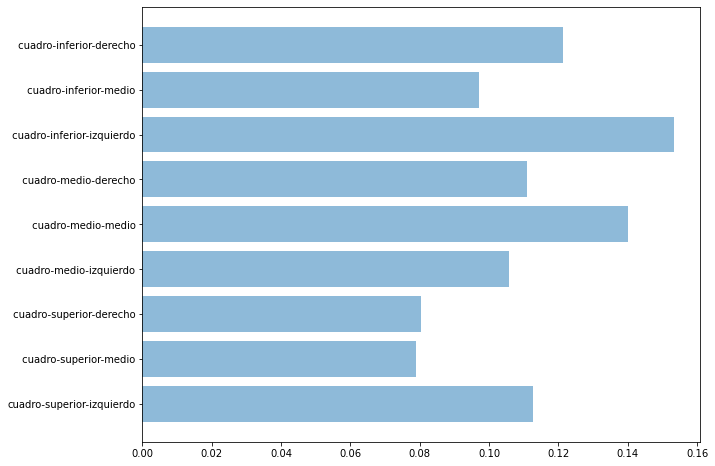

In [68]:
prediccionADABosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de ADA BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [69]:
prediccionXGBoosting = PrediccionXGBoosting(datos=datosTicTacToe)
prediccionXGBoosting.entrenamiento(train_size=0.80)


Matriz de Confusión:
[[ 53  21]
 [  2 116]]

Precisión Global:
0.8802083333333334

Error Global:
0.11979166666666663

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.716216                 0.983051


[0.11106831 0.08060148 0.08199095 0.09962354 0.14000401 0.10164083
 0.15780867 0.11104057 0.11622163]


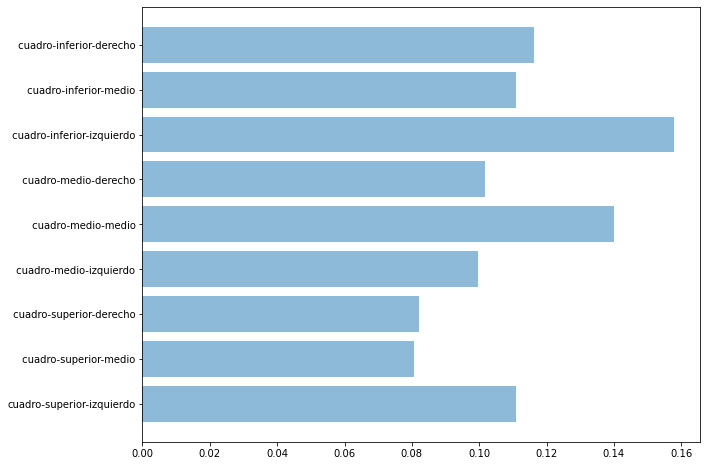

In [70]:
prediccionXGBoosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de XG BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [71]:
prediccionRandomForest = PrediccionRandomForest(datos=datosTicTacToe)
prediccionRandomForest.entrenamiento(train_size=0.80)


Matriz de Confusión:
[[ 61  13]
 [  6 112]]

Precisión Global:
0.9010416666666666

Error Global:
0.09895833333333337

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.824324                 0.949153


[0.1336949  0.08313247 0.13065682 0.07490372 0.1418822  0.10285765
 0.10626768 0.11441025 0.1121943 ]


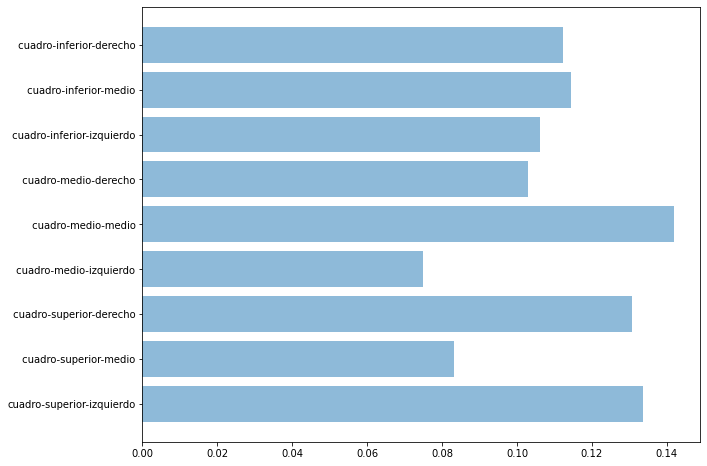

In [72]:
prediccionRandomForest.obtenerVariablesImportantes()

Sin modificar ningun parametro podemos ver como el algorimo de bosques aleatorios por consenso, en este caso esta prediciendo mejor que los algoritmos por metodos de potenciación. Una cosa muy interesante con esto es que el metodo de concenso utiliza como variable mas importante el cuadro del medio medio, mientras que los otros no escogen esta variable como mas importante, si no que escogen las esquinas inferiores o superiores.

Ademas de que tiene una precision global mejor que los otros tambien tiene, la presicion positiva y la precision negativa, muy superior a las otras.


In [73]:
reporteFinal = pd.concat([prediccionADABosting.reporte, prediccionXGBoosting.reporte, prediccionRandomForest.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios ADA Boosting,0.890625,0.109375,115,56,3,18,0.756757,0.974576
0,Bosques Aleatorios XG Boosting,0.880208,0.119792,116,53,2,21,0.716216,0.983051
0,Bosques Aleatorios,0.901042,0.098958,112,61,6,13,0.824324,0.949153



Matriz de Confusión:
[[1226    1]
 [   6  392]]

Precisión Global:
0.9956923076923077

Error Global:
0.004307692307692346

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.999185                 0.984925
[0.02685367 0.11321789 0.00738241 0.03796637 0.25958745 0.07680108
 0.29662114 0.07367063 0.01720881 0.07551571 0.01330616 0.0018687 ]


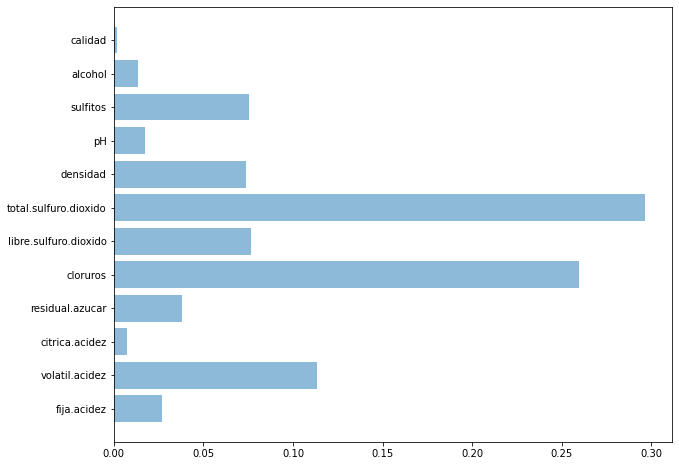

In [74]:
datosWine = pd.read_csv("wine.csv")
prediccionRandomForest = PrediccionRandomForest(datosWine)
prediccionRandomForest.entrenamiento(train_size=0.75)
prediccionRandomForest.obtenerVariablesImportantes()



Matriz de Confusión:
[[1217   10]
 [  14  384]]

Precisión Global:
0.9852307692307692

Error Global:
0.014769230769230757

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                  0.99185                 0.964824
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan -2.97268777e-02             nan  8.91266404e-05]


/home/william/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:605: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


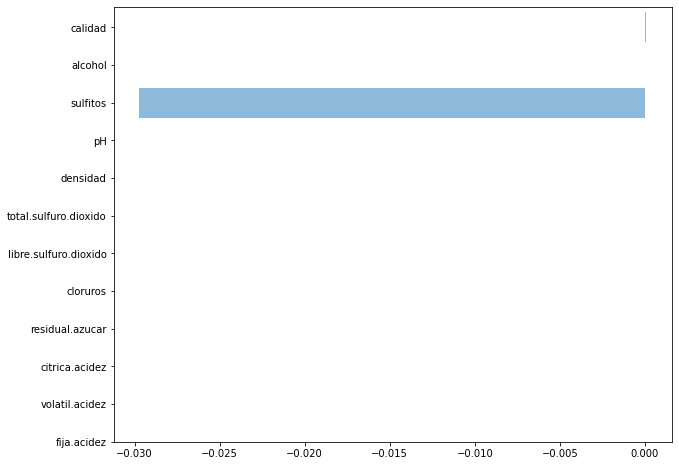

In [75]:
prediccionADABoosting = PrediccionADABoosting(datosWine)
prediccionADABoosting.entrenamiento(train_size=0.75)
prediccionADABoosting.obtenerVariablesImportantes()


Matriz de Confusión:
[[1219    8]
 [  14  384]]

Precisión Global:
0.9864615384615385

Error Global:
0.0135384615384615

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                  0.99348                 0.964824
[0.00336954 0.04335976 0.00070099 0.01017999 0.20485135 0.00111279
 0.6836528  0.01768589 0.01188626 0.01531976 0.00545288 0.002428  ]


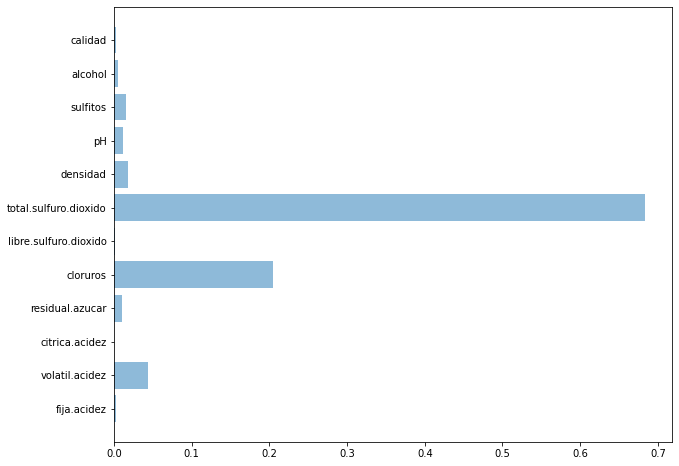

In [76]:
prediccionXGBoosting = PrediccionXGBoosting(datosWine)
prediccionXGBoosting.entrenamiento(train_size=0.75)
prediccionXGBoosting.obtenerVariablesImportantes()

En este caso sin la edicion de los parametros por defectos podemos observar que el metodo de bosques aleatorios esta prediciendo muy bien, aunque en realidad todos estan prediciendo bien y eso se puede notar tanto en la precision global, como en la precision positiva, y en la precision negativa.


Sin embargo el de bosques aleatorios es superior por que es superior en todas las categorias, una cosa interesante es ver que la variable mas importante para esta clasificacion es la variable mas importante que es : total.sulfuro.dioxido.

In [77]:
reporteFinal = pd.concat([prediccionRandomForest.reporte, prediccionADABoosting.reporte, prediccionXGBoosting.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios,0.995692,0.004308,392,1226,6,1,0.999185,0.984925
0,Bosques Aleatorios ADA Boosting,0.985231,0.014769,384,1217,14,10,0.991850,0.964824
0,Bosques Aleatorios XG Boosting,0.986462,0.013538,384,1219,14,8,0.993480,0.964824
